In [1]:
import pandas as pd

In [2]:
data= pd.read_csv(r"C:\Users\LP_UNDERGROUND\Downloads\cleaned_data_v1.csv", delimiter='\t')

In [3]:
data.shape

(3362, 2)

In [4]:
data.info

<bound method DataFrame.info of       dispute                                          complaint
0           0  I am a homeownership advisor with XXXX. On XXX...
1           0  I Want to file a complaint about XXXX For Fore...
2           0  I live in XXXX, my former mortgage holder, XXX...
3           0  My wife & I had a FHA backed XXXX yr XXXX serv...
4           0  I have been in review with my lender for XXXX ...
...       ...                                                ...
3357        0  i had the same issue with this company before ...
3358        0  One day My husband decided to check his credit...
3359        0  To whom it may concern : The investor or owner...
3360        0  My XXXX was modified on XXXX, 2013. While I si...
3361        0  Due to a weather events our house sustained da...

[3362 rows x 2 columns]>

In [5]:
for col in data.columns:
    print(col)

dispute
complaint


In [6]:
data['complaint'].str.len()
#data['complaint'].str.len().hist()

0        187
1        572
2       3143
3       1151
4        630
        ... 
3357     335
3358    1840
3359    3446
3360     536
3361     886
Name: complaint, Length: 3362, dtype: int64

<AxesSubplot:>

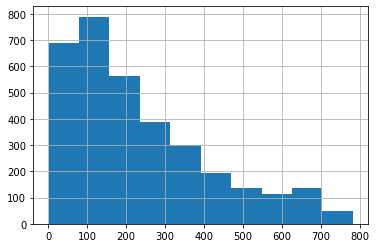

In [7]:
data['complaint'].str.split().\
    map(lambda x: len(x)).\
    hist()

<AxesSubplot:>

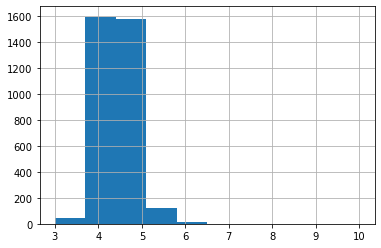

In [8]:
import numpy as np
data['complaint'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()

In [9]:
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
stop=set(stopwords.words('english'))

In [10]:
corpus=[]
new= data['complaint'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
    

42


<AxesSubplot:>

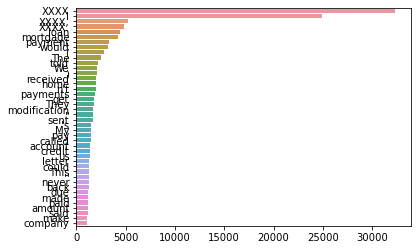

In [11]:
import seaborn as sns
from collections import Counter
counter=Counter(corpus)
most=counter.most_common()
#print(most)
x, y= [], []
for word,count in most[:100]:
    if (word not in stop):
        x.append(word)
        y.append(count)
print(len(x))
sns.barplot(x=y,y=x)

<AxesSubplot:>

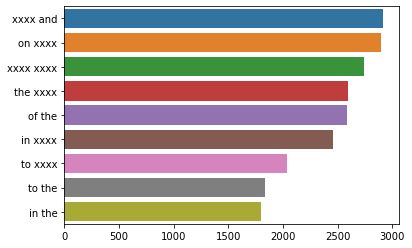

In [12]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

top_n_bigrams=get_top_ngram(data['complaint'],2)[:-1] 
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)


<AxesSubplot:>

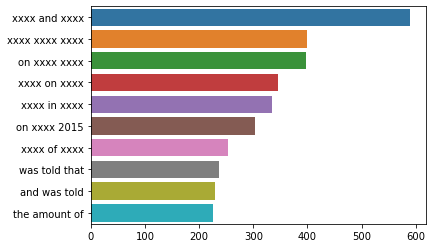

In [13]:
top_tri_grams=get_top_ngram(data['complaint'],n=3)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)

In [14]:
#Topic Modelling using LDA
import nltk
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import word_tokenize
import gensim
from gensim.corpora import Dictionary
#import pyLDAvis.gensim
import pyLDAvis
#import pyLDAvis.gensim as gensimvis   #-----------------------------
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

def get_lda_objects(text):
    #nltk.download('stopwords')    
    #stop=set(stopwords.words('english'))

    
    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    
    return lda_model, bow_corpus, dic

In [15]:
def plot_lda_vis(lda_model, bow_corpus, dic):
    vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
    return vis

In [16]:
lda_model, bow_corpus, dic = get_lda_objects(data['complaint'])
lda_model.show_topics()

[(0,
  '0.117*"XXXX" + 0.018*"loan" + 0.016*"mortgage" + 0.011*"payment" + 0.009*"modification" + 0.008*"The" + 0.007*"home" + 0.006*"credit" + 0.005*"received" + 0.005*"letter"'),
 (1,
  '0.110*"XXXX" + 0.026*"payment" + 0.011*"mortgage" + 0.010*"would" + 0.008*"account" + 0.008*"told" + 0.008*"month" + 0.007*"call" + 0.007*"called" + 0.007*"received"'),
 (2,
  '0.081*"XXXX" + 0.023*"loan" + 0.010*"payment" + 0.010*"would" + 0.009*"mortgage" + 0.007*"rate" + 0.007*"interest" + 0.006*"pay" + 0.006*"told" + 0.006*"month"'),
 (3,
  '0.073*"XXXX" + 0.018*"home" + 0.015*"sale" + 0.010*"loan" + 0.010*"house" + 0.009*"modification" + 0.008*"year" + 0.008*"foreclosure" + 0.008*"short" + 0.007*"mortgage"')]

In [17]:
plot_lda_vis(lda_model, bow_corpus, dic)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.049796 -0.037697       1        1  39.962554
0      0.010249 -0.016426       2        1  30.736884
2      0.029505  0.057892       3        1  15.175042
3     -0.089550 -0.003768       4        1  14.125519, topic_info=      Term          Freq         Total Category  logprob  loglift
39    loan   5180.000000   5180.000000  Default  30.0000  30.0000
258   sale   1121.000000   1121.000000  Default  29.0000  29.0000
1     XXXX  40661.000000  40661.000000  Default  28.0000  28.0000
36    home   2655.000000   2655.000000  Default  27.0000  27.0000
479  house   1174.000000   1174.000000  Default  26.0000  26.0000
..     ...           ...           ...      ...      ...      ...
202  could    206.034351   1265.328478   Topic4  -5.6069   0.1421
13    told    233.141575   2111.253706   Topic4  -5.4833  -0.2462
241   date    178.359780    941.790654   Topic4  -5.7512   0.2932
22    back    196.815964   1416.259213   Topic4  -5.6527  -0.0163
101    day    201.715375   1560.427599   Topic4  -5.6281  -0.0887

[371 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
14407      3  0.901885      -made
14408      3  0.935642      -paid
11056      4  0.841815    1024.41
4106       1  0.046702  120000.00
4106       2  0.233508  120000.00
...      ...       ...        ...
53         1  0.328415       year
53         2  0.251934       year
53         3  0.182952       year
53         4  0.236938       year
16571      3  0.972103        ytd

[814 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 4])

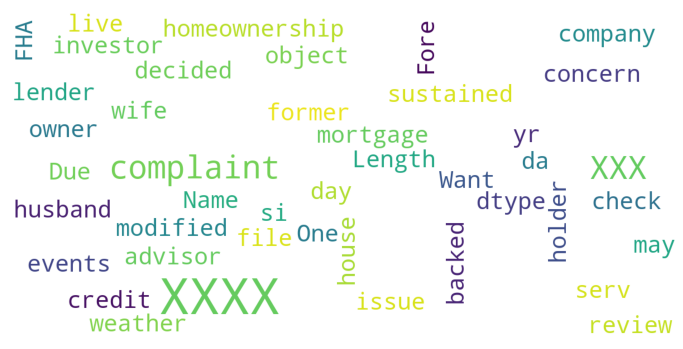

In [18]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(data['complaint'])

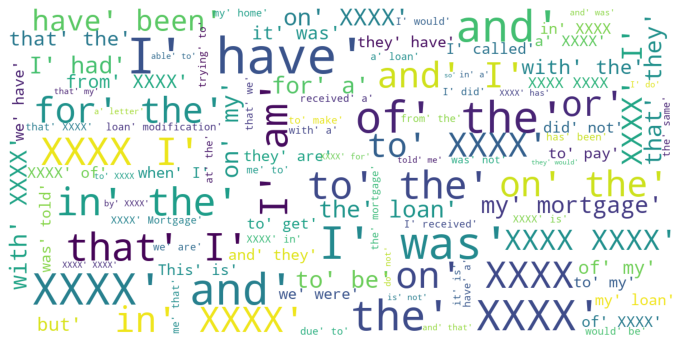

In [19]:
show_wordcloud(corpus)

<AxesSubplot:>

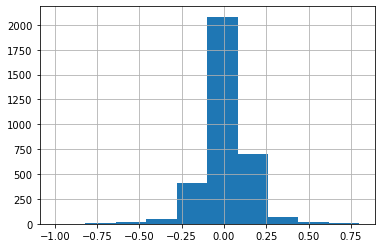

In [20]:
# Sentiment Analysis
from textblob import TextBlob
def polarity(text):
    return TextBlob(text).sentiment.polarity

data['polarity_score']=data['complaint'].\
   apply(lambda x : polarity(x))
data['polarity_score'].hist()

<BarContainer object of 3 artists>

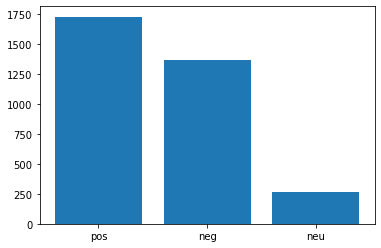

In [21]:
def sentiment(x):
    if x<0:
        return 'neg'
    elif x==0:
        return 'neu'
    else:
        return 'pos'
    
data['polarity']=data['polarity_score'].\
   map(lambda x: sentiment(x))

plt.bar(data.polarity.value_counts().index,
        data.polarity.value_counts())

In [22]:
data[data['polarity']=='pos']['complaint'].head()

2     I live in XXXX, my former mortgage holder, XXX...
3     My wife & I had a FHA backed XXXX yr XXXX serv...
5     XXXX denied loan modification for property tha...
8     XXXX foreclosed on my XXXX-year-old mother 's ...
10    To whom it may XXXX sold our loan to CMPNY4785...
Name: complaint, dtype: object

In [23]:
data[data['polarity']=='neg']['complaint'].head()

1    I Want to file a complaint about XXXX For Fore...
4    I have been in review with my lender for XXXX ...
6    XXXX mortgage transfered my loan to XXXX with ...
7    Almost impossible to reach anyone on phone. HA...
9    My former mortgage company was bought out by G...
Name: complaint, dtype: object

In [24]:
data[data['polarity']=='neu']['complaint'].head()

0      I am a homeownership advisor with XXXX. On XXX...
74     I haved lived in thos house for 7 years+. Ever...
108    I refinance my house note as I was doing it pa...
162                     I feel that we were overcharged.
167    I have a home mortgage. It is owned by XXXX. X...
Name: complaint, dtype: object

In [25]:
#Named Entity recognition
import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")

def ner(text):
    doc=nlp(text)
    return [X.label_ for X in doc.ents]

ent=data['complaint'].\
    apply(lambda x : ner(x))
ent=[x for sub in ent for x in sub]

counter=Counter(ent)
count=counter.most_common()

<AxesSubplot:>

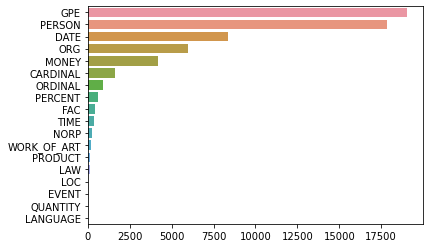

In [26]:
x,y=map(list,zip(*count))
sns.barplot(x=y,y=x)

C:\Users\LP_UNDERGROUND\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

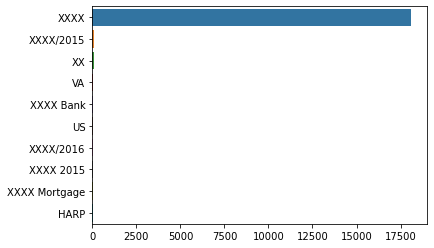

In [29]:
def ner(text,ent="GPE"):
    doc=nlp(text)
    return [X.text for X in doc.ents if X.label_ == ent]

gpe=data['complaint'].apply(lambda x: ner(x))
gpe=[i for x in gpe for i in x]
counter=Counter(gpe)

x,y=map(list,zip(*counter.most_common(10)))
sns.barplot(y,x)

C:\Users\LP_UNDERGROUND\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

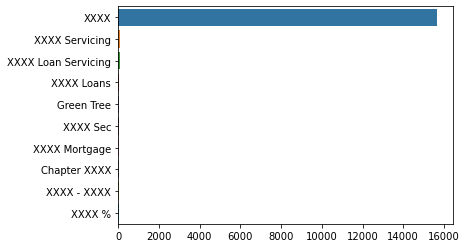

In [30]:
#finding out common names as per dataset
per=data['complaint'].apply(lambda x: ner(x,"PERSON"))
per=[i for x in per for i in x]
counter=Counter(per)

x,y=map(list,zip(*counter.most_common(10)))
sns.barplot(y,x)